In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch
from koopman.simulation.systems import DynamicalSystem, VanDerPolOscillator
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.chebyshev import Chebyshev
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d

def get_random_visible_color():
    # Sample hue randomly, fix saturation and value for vibrancy
    h = np.random.rand()           # Hue ∈ [0, 1]
    s = np.random.uniform(0.6, 1)  # Saturation: avoid pale colors
    v = np.random.uniform(0.7, 1)  # Value (brightness): avoid dark
    return mcolors.hsv_to_rgb((h, s, v))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Run a simulation with the Van Der Pol system
vanderpol = VanDerPolOscillator()

N = 100
x0 = np.random.uniform(-1, 1, (N, 2))
tf = 10.0
dt = 0.05
T = int(tf/dt)
# controls = np.random.randn(N, T, 1) * 5.0
controls = np.zeros((N, T, 1)) #np.random.randn(N, T, 1) * 5.0

ts, xhist, uhist = simulate_batch(
    sys=vanderpol,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print(f"Simulation finished. {xhist.shape=}, {uhist.shape=}")

Simulation progress:   0%|          | 0/200 [00:00<?, ?it/s]

Simulation progress: 100%|██████████| 200/200 [00:00<00:00, 3237.67it/s]

Simulation finished. xhist.shape=(100, 201, 2), uhist.shape=(100, 200, 1)


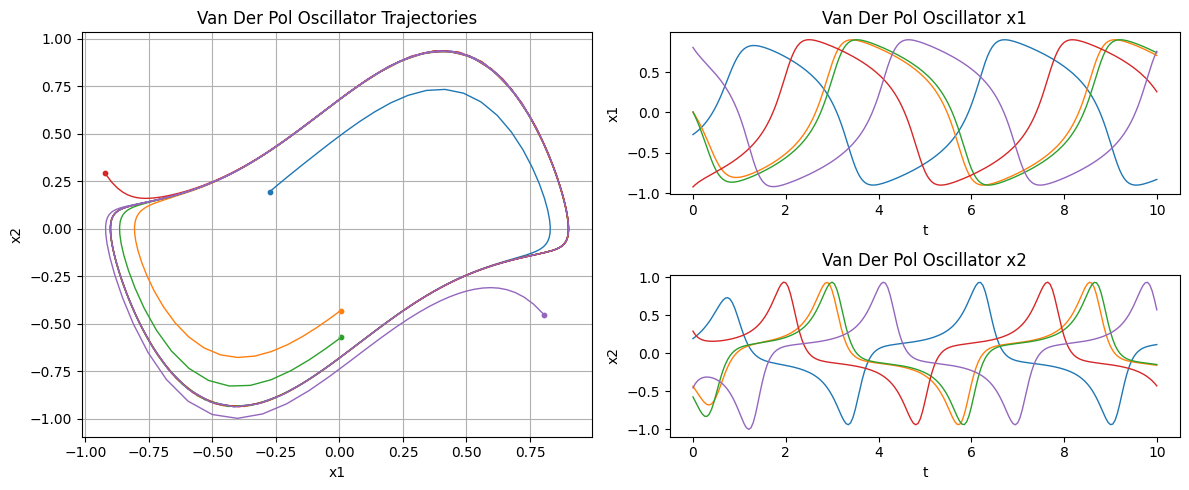

In [15]:
trajectory_samples = xhist[np.random.randint(0, N, 5), :, :]

# Plot the trajectory
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
ax_x1 = fig.add_subplot(gs[0, 1])
ax_x2 = fig.add_subplot(gs[1, 1])

for i in range(trajectory_samples.shape[0]):
    x = ax_traj.plot(trajectory_samples[i, :, 0], trajectory_samples[i, :, 1], linewidth=1)
    _ = ax_traj.scatter(trajectory_samples[i, 0, 0], trajectory_samples[i, 0, 1], color=x[0].get_color(), s=10)
    
    _ = ax_x1.plot(ts, trajectory_samples[i, :, 0], linewidth=1)
    _ = ax_x2.plot(ts, trajectory_samples[i, :, 1], linewidth=1)

ax_traj.set_title("Van Der Pol Oscillator Trajectories")
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.grid()

ax_x1.set_title("Van Der Pol Oscillator x1")
ax_x1.set_xlabel("t")
ax_x1.set_ylabel("x1")

ax_x2.set_title("Van Der Pol Oscillator x2")
ax_x2.set_xlabel("t")
ax_x2.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [82]:
# Hand-pick the observables
def generate_thin_plate_rbf(nx, n_centers=100):
    centers = np.random.uniform(-1, 1, (n_centers, nx))
    # centers = np.linspace(-1, 1, n_centers).reshape(-1, 1) * np.ones((1, nx))
    
    def evaluate(X):
        # Compute the radial basis function values
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=-1)  # shape: (B, num_centers)
        with np.errstate(divide='ignore', invalid='ignore'):
            rbf = dists**2 * np.log(dists)
            rbf[np.isnan(rbf)] = 0.0  # set r=0 cases to 0
        
        return rbf
    
    return evaluate

rbf_generator = generate_thin_plate_rbf(nx=VanDerPolOscillator.nx, n_centers=100)

Tn = lambda n : Chebyshev([0] * n + [1])

T2 = Tn(2)
T3 = Tn(3)
T4 = Tn(4)

poly = PolynomialFeatures(degree=3, include_bias=False)

def koopman_observables(xhist: np.ndarray) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    Y1 = rbf_generator(xhist)  # shape(B, num_centers)
    # Y2 = np.sin(xhist)  # shape(B, nx)
    # Y3 = np.cos(xhist)  # shape(B, nx)
    # Y4 = np.sin(2*xhist)  # shape(B, nx)
    # Y5 = np.cos(2*xhist)  # shape(B, nx)
    # Y6 = np.sin(4*xhist)  # shape(B, nx)
    # Y7 = np.cos(4*xhist)  # shape(B, nx)
    C2 = T2(xhist)  # shape(B, nx)
    C3 = T3(xhist)  # shape(B, nx)
    C4 = T4(xhist)  # shape(B, nx)
    
    phi_X = poly.fit_transform(xhist)
    
    # out = np.concatenate([xhist, Y1, Y2, Y3, Y4, Y5, Y6, Y7], axis=-1)
    out = np.concatenate([xhist, Y1, C2, C3, C4, phi_X], axis=-1)
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to the data using the observable
edmd = eDMD()
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)
_ = edmd.fit(zhist, uhist, bilinear=False)

Fitting EDMD model with data:
	zhist.shape=(100, 201, 117)
	uhist.shape=(100, 200, 1)
	# of trajectories: 100
	# of time steps: 201
	# of lifted states: 117
	# of controls: 1
Fitting results:
	self.kpA.shape=(117, 117)
	self.kpB.shape=(117, 1)
	A condition number: 3.7485107714078854e+17
	B condition number: inf


In [83]:
# Evaluate the model on some new data
# x0 = np.random.uniform(-1, 1, 2)
x0 = np.array([0.5, 0.5])

ts = np.arange(0, tf, dt)
controls = np.zeros((T, 1))

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=vanderpol,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

# Simulate the system with the learned model
zjm1 = koopman_observables(x0)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1, VanDerPolOscillator.nx)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj, VanDerPolOscillator.nx)
    
    zjm1 = zj

Simulation progress: 100%|██████████| 200/200 [00:00<00:00, 15385.45it/s]


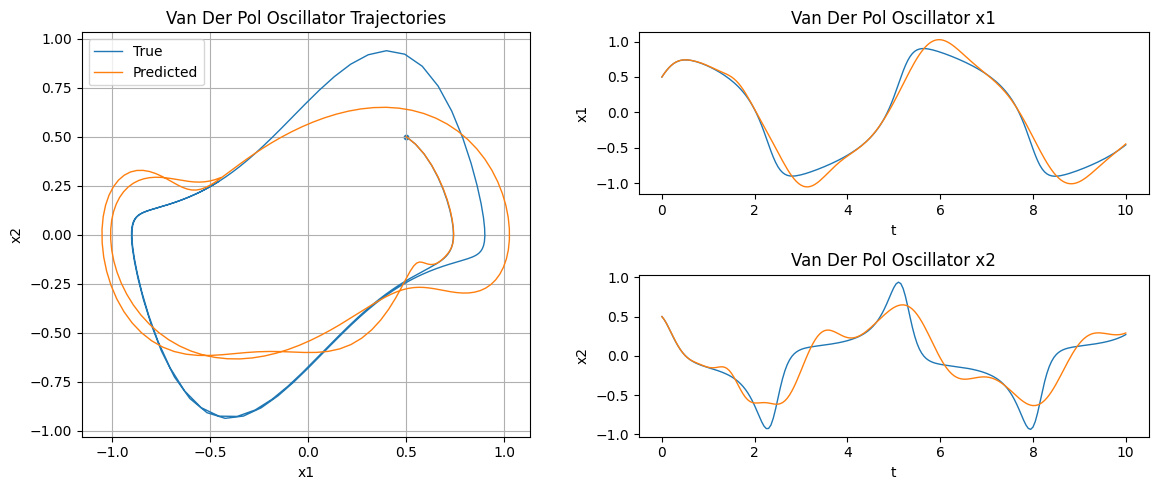

In [84]:
# Plot the trajectory
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax_traj = fig.add_subplot(fig.add_subplot(gs[:, 0]))
ax_x1 = fig.add_subplot(gs[0, 1])
ax_x2 = fig.add_subplot(gs[1, 1])

x = ax_traj.plot(eval_xhist[:, 0], eval_xhist[:, 1], linewidth=1, label="True")
_ = ax_traj.plot(eval_xhist_pred[:, 0], eval_xhist_pred[:, 1], linewidth=1, label="Predicted")
ax_traj.scatter(eval_xhist[0, 0], eval_xhist[0, 1], color=x[0].get_color(), s=10)
ax_traj.set_title("Van Der Pol Oscillator Trajectories")
ax_traj.set_xlabel("x1")
ax_traj.set_ylabel("x2")
ax_traj.grid()
ax_traj.legend()
ax_traj.set_aspect('equal', adjustable='box')

ax_x1.plot(eval_ts, eval_xhist[:, 0], linewidth=1, label="True")
ax_x1.plot(eval_ts, eval_xhist_pred[:, 0], linewidth=1, label="Predicted")
ax_x1.set_title("Van Der Pol Oscillator x1")
ax_x1.set_xlabel("t")
ax_x1.set_ylabel("x1")

ax_x2.plot(eval_ts, eval_xhist[:, 1], linewidth=1, label="True")
ax_x2.plot(eval_ts, eval_xhist_pred[:, 1], linewidth=1, label="Predicted")
ax_x2.set_title("Van Der Pol Oscillator x2")
ax_x2.set_xlabel("t")
ax_x2.set_ylabel("x2")

plt.tight_layout()
plt.show()